In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Hierarchical linear regression


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..

*  Chris Fonnesbeck, <a href="https://github.com/fonnesbeck/bayes_course_july2020">Bayesian Computing Course</a>
*  O. Martin, *Bayesian analysis with Python*, Ch. 3

# Hierarchical regression

* Hierarchical  regression is  a generalization of linear regression, which allows the  parameters to **vary by group**.


* This allows modelling observations which are  *grouped*  (also referred to as *clustered*). 

# Hierarchical (or multilevel) modeling

A *hierarchical model* provides an intermediate (and often more sensible) approach between:

    
* the *pooled model*, which merges the observations from all clusters, fitting a single regression.  This might be  excessively constrained; 

* the *unpooled model*, which fits an independent regression to each cluster. Estimates are however unreliable on cluster containing few observations and there is no generalization to unobserved groups.

# The radon data set (Gelman et al., 2007)

<img src='img/how_radon_enters.jpg' width=400 align="center" >

# The radon data set (Gelman et al., 2007)

* The amount of the radioactive gas radon has been measured among different households in all counties of several states.


* Radon gas is  the highest cause of lung cancer in non-smokers.



* Its level is  generally higher in the basement; moreover, its presence depends on the  type of soil.

# Radon contamination in Minnesota

* We will model radon levels in Minnesota. The state is divided in different *counties*.


* The EPA measured the radon level in many households.


* For each measure we know:
    * the county
    * whether the measurement is in basement or in the  first floor 
    * average  uranium level in the county (positively correlated with radon)

### Data organization

In [3]:
# Import radon data, 919 rows
#Eventually we have log_radon_std (Y), floor_std (X) and the 
#index of the county in which the measurement has been taken.

radon_data = pd.read_csv('data/radon.csv', index_col=0)


#list of  counties in Minnesota (J=85 different counties)
counties      = radon_data.county.unique()
n_counties = counties.shape[0] 

#numerical id of the county, 919 rows (one for each measure)
county               = radon_data.county_code.values
#code and name of each county
county_lookup = dict(zip(counties, np.arange(n_counties)))


#explanatory variable: the floor. It is either 0 (ground level) or 1 (first floor).
#we standardize x to avoid correlation in the posterior.
floor           = radon_data.floor.values
floor_std   = (floor - floor.mean()) / floor.std()

#y 
log_radon         = radon_data.log_radon.values
#standardization of y is useful to set the prior without worrying about the scale of the data.
log_radon_std = (log_radon - log_radon.mean()) / log_radon.std()

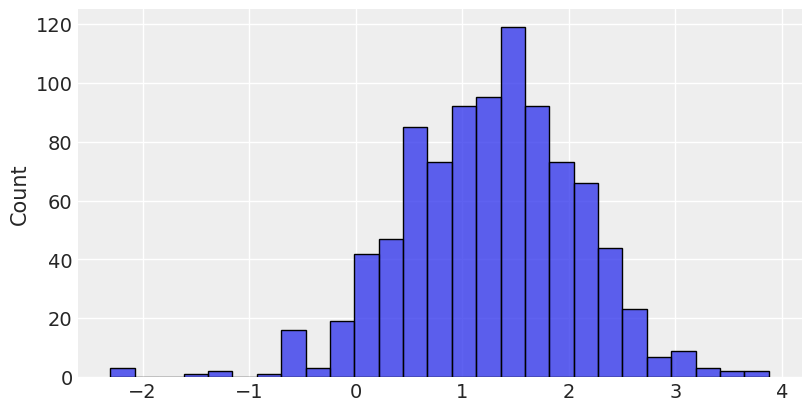

In [4]:
#Distribution of radon levels in MN (log scale):

sns.histplot(log_radon);

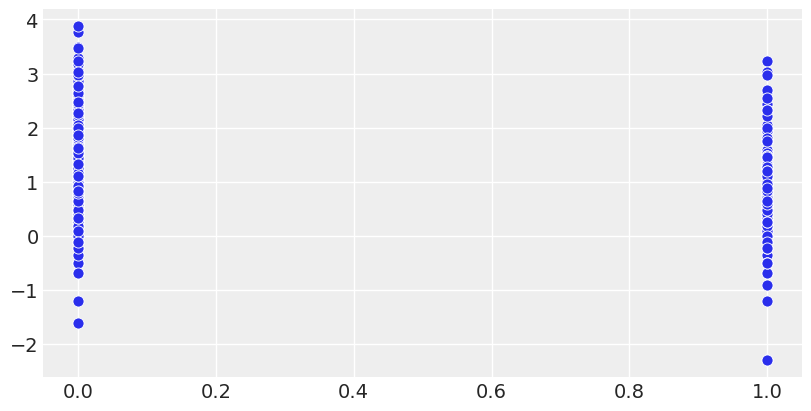

In [5]:
#as floor takes only 0 and 1 as values, we have data organized into two columns 
#The radon level is higher in the basement (floor = 0) than in the first floor (floor = 1).
sns.scatterplot(floor, log_radon);

# Pooled regression

Fit a single regression:

$$y_i = \alpha + \beta x_i + \epsilon_i$$


* $y_i$: log-radon measured in the $i$-th household ($i$=1,2,...919)

* $\alpha$ : intercept.  (On  centered the data, it represents the mean log-radon in Minnesota). 

* $x_i$: floor of the measurement in the $i$-th household (1 or 0, where 0 means basement)

* $\epsilon_i$:  noise


# Priors

We have no prior knowledge; we thus set   data-dependent priors which  provide information about the order of magnitude of the data (weakly informative).

\begin{align*}
 \alpha & \sim N(\bar{y}, 2 \sigma_y) \\
\beta & \sim  N(0, 2 \frac{\sigma_y}{\sigma_x}) \\
\sigma_{\epsilon} & \sim \text{HalfNormal} (\sigma_y)\\
\end{align*}




# Priors

On standardized data ($\sigma_y = 1, \sigma_x =1$) , the previous prior becomes:

\begin{align*}
 \alpha & \sim N(\bar{y}, 2) \\
\beta & \sim  N(0, 2) \\
\sigma_{\epsilon} & \sim \text{HalfNormal} (1)\\
\end{align*}



* These are  reasonable defaults;  if in doubt, try the model under different priors.


## Pooled model

Assuming standardized data the full model is:

\begin{align}
\beta  & \sim N (0,2)  && \text{prior on the slope for standardized data} \\
\alpha &\sim N(0,2) && \text{prior on the intercept for standardized data} \\
\sigma_{\epsilon} &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std of the noise} \\
y_i  &\sim N( \alpha + \beta x_i,  \sigma_{\epsilon}) && \text{likelihood}
\end{align}

# Unpooled model

* There are $J$=85 different counties.

*  The intercept is independently estimated of  for each county:

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* $\alpha_{j[i]}$ : the intercept for the county where household $i$ is located (in the subscript, $j$ can be thought of as an array containing the country code for each measure)

# Unpooled model


$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* The intercept  varies with the  county. We can think of the intercept as the log-radon level for an average value of $x$, i.e., an average between floor and basement level for that county.

# Unpooled model


$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* The slope $\beta$ is equal for all counties; we assume that the difference between floor and basement does not depend on the county.



# Unpooled model

We will fit, independently for each county,  the model: 

\begin{align}
\beta & \sim N (0,2)  && \text{prior on the slope for standardized data} \\
\alpha_j &\sim N(0,2) \,\, j=1,2..., 85&& \text{prior on the intercept for standardized data} \\
\sigma_{\epsilon} &\sim \text{HalfNormal}(0,1) && \text{prior on the noise dev std,  for standardized y} \\
y_i  &\sim N( \alpha_{j[i]} + \beta x_i,  \sigma_{\epsilon}) && \text{likelihood}
\end{align}

# Discussion

* Pooled model: we assume that all observations are samples from the same process,  ignoring any variation due to the county.


* Unpooled model: we imply that differences between counties are so large that each county needs its own model. We learn from scratch every model, without transferring any information between models.

# Implementation

In [6]:
#pooled model

with pm.Model() as pooled_model:

    alpha = pm.Normal('alpha', mu=0,  sigma=2)
    beta   = pm.Normal('beta', mu=0,  sigma=2)
    sigma = pm.HalfNormal('sigma', 1)
    
    y = pm.Normal('y', alpha + beta*floor_std, sigma, observed=log_radon_std)
    

In [7]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1046 seconds.


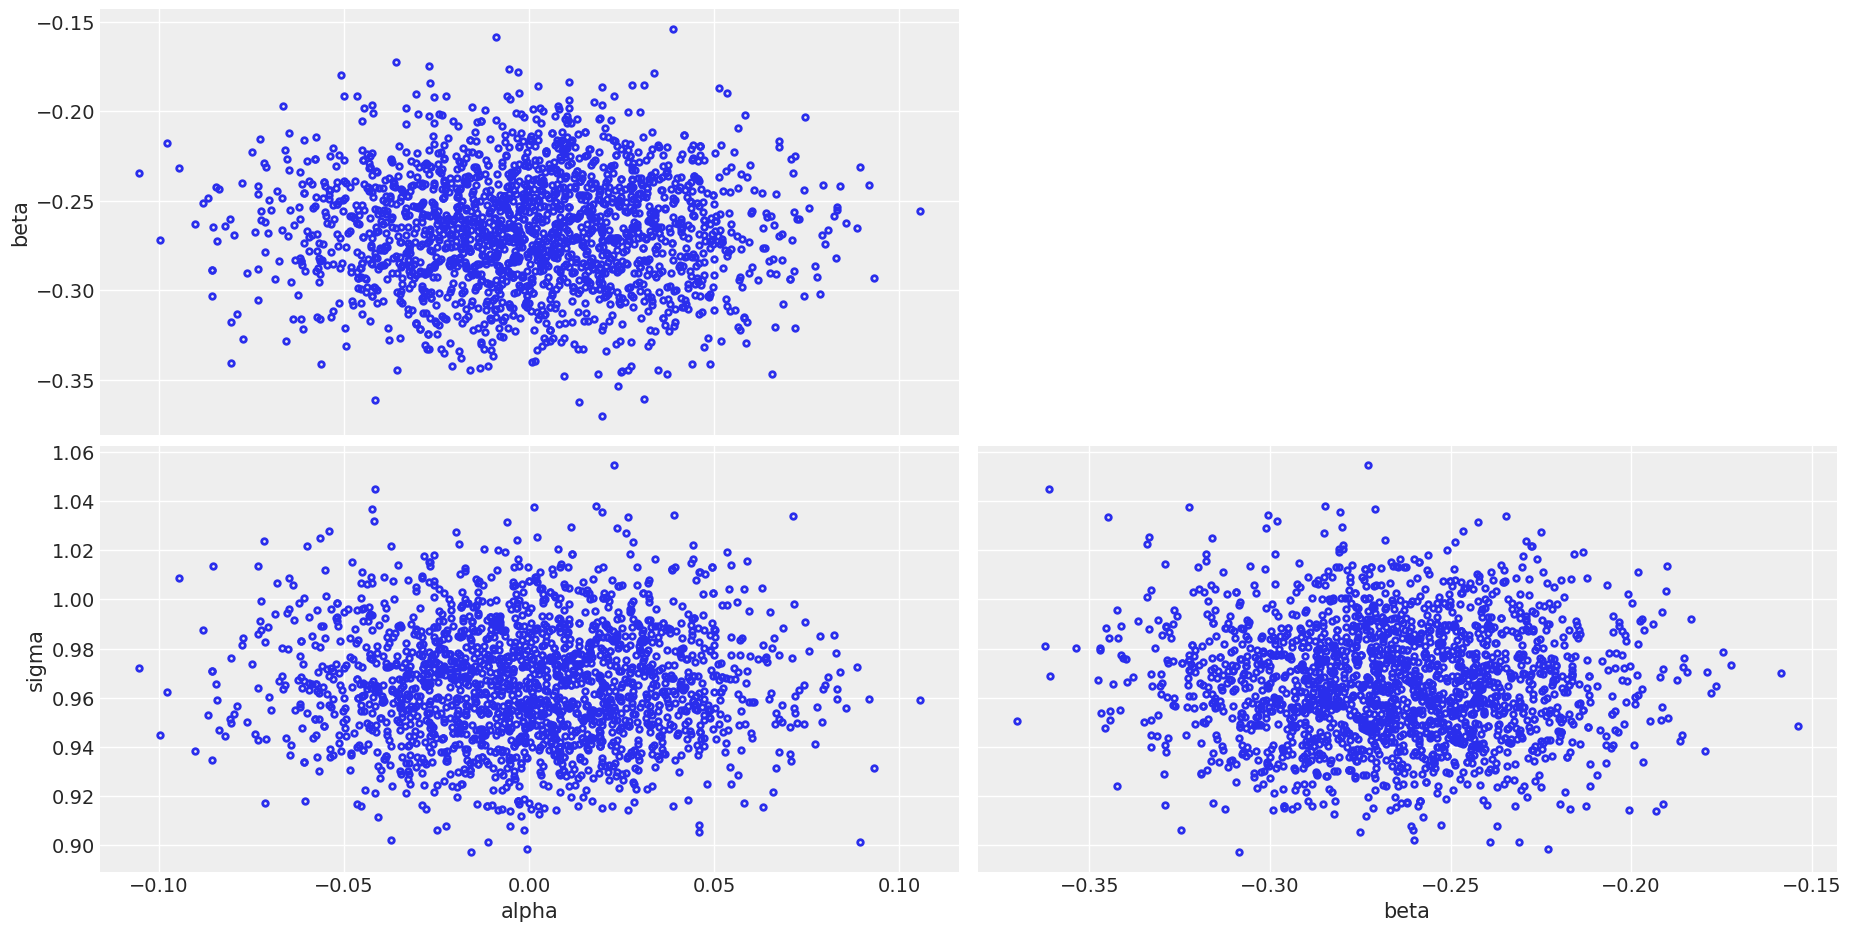

In [8]:
    #standardization of x removes correlation in the posterior.
with pooled_model:
        az.plot_pair(pooled_trace);

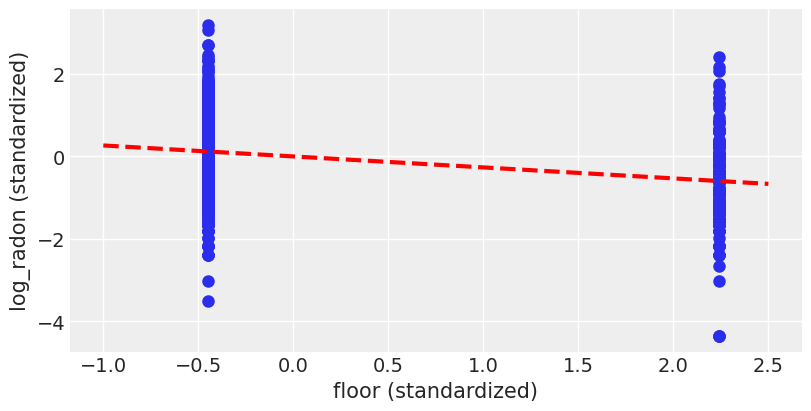

In [9]:
# posterior mean of the parameters
a_hat =  pooled_trace['alpha'].mean(axis=0)
b_hat = pooled_trace['beta'].mean(axis=0)

plt.scatter(floor_std, log_radon_std)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_hat*xvals + a_hat, 'r--')
plt.xlabel('floor (standardized)')
plt.ylabel('log_radon (standardized)');

# Unpooled model

In [10]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=n_counties)

    # the slope is the same for all counties
    beta = pm.Normal('beta', mu=0, sigma=10)
    σ   = pm.HalfNormal('σ', 5)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[county] + beta *floor_std
    
    y = pm.Normal('y', mu, sigma=σ, observed=log_radon_std)
    

In [11]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, beta, alpha]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ValueError: Not enough samples to build a trace.

Comparing the pooled and unpooled model

In [ ]:
#GRAFICO NON FUNZIONA

#we select a subset of counties
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the unpooled model (posterior mean)
beta_unpooled = unpooled_trace['beta'].mean()
# intercept of the unpooled model (posterior mean): an array, one element for each county.
alpha_unpooled = pd.Series(unpooled_trace['alpha'].mean(axis=0), index=counties)

for i,c in enumerate(sample_counties):
    #select the subset of observation referring to the specific county
    y = log_radon_std[radon_data.county==c]
    x = floor_std[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # Unpooled intercept
    current_a = alpha_unpooled[c]
    
    # Plot both models and data
    xvals = np.linspace(floor_std.min(), floor_std.max() )
    axes[i].plot(xvals,  current_a * xvals + beta_unpooled)
    axes[i].plot(xvals, b_hat * xvals+a_hat, 'r--')
    axes[i].set_xticks([floor_std.min(), floor_std.max()])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon  (std_ed)')
plt.savefig('img/pooled_unpooled.png')

<img src='img/pooled_unpooled.png' width=1000 align="center" >

* the pooled model (red) does not identify high-radon counties
* the unpooled models (blue) yields extreme  estimates in counties where few observations are available, as in LAC QUI PARLE case.

# Hierarchical (or multilevel) models

* Like the unpooled model,  the hierarchical model has  a separate intercept for each county.


* Rather than fitting an independent regression for each county, it **shares strength** among counties, allowing for more reasonable inference in counties with little data (borrowing strength).

# Hierarchical  models

* They can be used to model data collected by a set of individuals, where more than one observation is  from the same individual (or location, or time)
   
* ... or  to improve estimates for imbalance in sampling, when some individuals are sampled more than others:  hierarchical model improve the estimates of the less sampled individuals, by exploiting information from the other individuals (*borrowing statistical strenght*).

#  Hierarchical model

* For the moment, we only focus on the intercept.



* In the previous example, a hierarchical model would learn:
    * the population of households in each county, characterized by a common intercept;
    * the population of intercepts (one sample for each county).
    
* The model of the population of intercepts serves as a prior (loosely speaking) when learning the intercept of each county; yet such prior is learned together with each intercept by the hierarchical model.

#  Hierarchical models


* If the population of intercepts is  highly variable,  the distribution of the intercepts  over counties  uninformative.


* Thus the population of the intercepts has a uniform distribution; the prior for each county is uninformative.


* In this case,  the observations at any one county  will not impact  the estimate of another county.


* If instead the population of the intercepts is very concenterated variation, the prior is narrow and highly informative. 


* Estimates for the counties with limited number of observation will benefit by such informative prior.  Observation at any county will have an  impact on estimates also in  other counties, by impacting the prior.

# Varying intercept model

* We want a  model, in which we simultaneously estimate  an intercept for each county and how the intercept varies across counties.
* A *varying intercept* model is as follows:
    * for each county, it uses a different intercept 
    *  it learns  the prior that is common to all of these intercepts, i.e., the population of intercepts.
  

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [ ]:
with pm.Model() as hier_model:
    
    # Priors
    μ_a = pm.Normal('μ_a', mu=0., sigma=10)
    σ_a = pm.HalfCauchy('σ_a', 5)
    
    # Random intercepts
    a = pm.Normal('a', mu=μ_a, sigma=σ_a, shape=n_counties)
    
    # Common slope
    b = pm.Normal('b', mu=0, sigma=2)

    
    # Model error
    σ_y = pm.HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a[county] + b * floor_std
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon_std)    

In [ ]:
with hier_model:
    hier_trace = pm.sample(return_inferencedata=False)

In [ ]:
#the code below shows the amount of shrinkage (i.e, how much the unpooled estimate is pulled towards the global mean (pooled estimated)), 
# as a function of n_j, the number of observations available for each county.
sample_trace = hier_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
n_samples, n_counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=n_counties)

n_county = radon_data.groupby('county')['county_code'].count()
unpooled_means = radon_data.groupby('county')['log_radon'].mean()
unpooled_sd = radon_data.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
axes[0].set_title("Unpooled")
        
n_samples, n_counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(-3, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
axes[1].set_title("Hierarchical")
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-');
    
plt.savefig('img/shrinkage.png')


<img src='img/shrinkage.png' width=900 align="center" >

* For small sample sizes the estimates of the unpooled model are both more extreme and more uncertain compared to the hierarchical model.


* The estimates of the hierarchical model are smoothed towards the mean of the population and less uncertain.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.

* The WAIC score contain  two terms: one that measures how well the data fits the model and one penalizing complex models.

* From a practical point of view, you just need to know that we prefer lower values of   WAIC.


In [ ]:
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

In [ ]:
#TODO:CODICE DA RIVEDERE

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = radon_data.log_radon[radon_data.county==c]
    x = radon_data.floor[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    m = unpooled_trace['β1'].mean()
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level');

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [ ]:
#TODO: CODICE DA RIVEDERE
with pm.Model() as varying_slope:
    
    # Priors
    μ_b = Normal('μ_b', mu=0., sigma=10)
    σ_b = HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = Normal('a', mu=0., sigma=10)
    # Random slopes
    b = Normal('b', mu=μ_b, sigma=σ_b, shape=n_counties)
    
    # Model error
    σ_y = HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with varying_slope:
    varying_slope_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
(ax,) = plot_forest(varying_slope_trace, var_names=['b'])
ax.set_yticklabels([""]);

In [ ]:
xvals = np.arange(2)
b = varying_slope_trace['a'].mean()
m = varying_slope_trace['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

## Exercise: Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

Combine these two models to create a version with both slope and intercept varying.

In [ ]:
with Model() as varying_intercept_slope:
    
    # Write your model here

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Forest plot of slopes and intercepts:

In [ ]:
plot_forest(varying_intercept_slope_trace, var_names=['a','b']);

In [ ]:
xvals = np.arange(2)
b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [ ]:
county_lookup['ST LOUIS']

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is a matter of adding a single additional line in PyMC:

In [ ]:
with Model() as contextual_pred:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    
    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sigma=σ_y)
    

In [ ]:
with contextual_pred:
    contextual_pred_trace = sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
plot_posterior(contextual_pred_trace, var_names=['stl_pred']);

## Exercise

How would we make a prediction from a new county (*e.g.* one not included in this dataset)?

In [ ]:
# Write your answer here

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data
- Estimation of coefficients for (under-represented) groups
- Incorporating individual- and group-level information when estimating group-level coefficients
- Allowing for variation among individual-level coefficients across groups


---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Betancourt, M. J., & Girolami, M. (2013). Hamiltonian Monte Carlo for Hierarchical Models.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.